<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/jacques_autoencoder_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)


fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


# On va importer la BDD celebA ( utile uniquement si pas déjà sur mon drive )

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Chemin du fichier ZIP et dossier de destination
zip_path = '/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip'
extract_to = '/content/drive/MyDrive/img_align_celeba'

# Vérification du nombre d'images déjà extraites
existing_images = [
    f for f in os.listdir(extract_to)
    if f.lower().endswith('.jpg')
] if os.path.exists(extract_to) else []

nb_existing = len(existing_images)
print(f"{nb_existing} image(s) déjà présentes dans {extract_to}")

# Extraction uniquement si moins de 5000 images
if nb_existing < 5000:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        jpg_files = sorted([f for f in zip_ref.namelist() if f.lower().endswith('.jpg')])
        images_to_extract = jpg_files[nb_existing:5000]

        os.makedirs(extract_to, exist_ok=True)

        for file in images_to_extract:
            zip_ref.extract(file, extract_to)

        print(f"{len(images_to_extract)} image(s) ajoutée(s).")

else:
    print("Pas besoin d'extraction, 5000 images ou plus déjà présentes.")

# Affichage final du total
total_images = len([
    f for f in os.listdir(extract_to)
    if f.lower().endswith('.jpg')
])
print(f"Nombre total d'images maintenant dans {extract_to} : {total_images}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0 image(s) déjà présentes dans /content/drive/MyDrive/img_align_celeba


KeyboardInterrupt: 

(218, 178, 3)


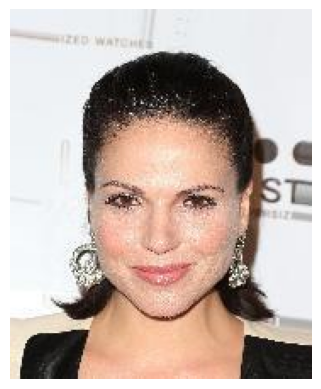

In [ ]:
import cv2
import matplotlib.pyplot as plt


img_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba/005000.jpg'

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print (img_rgb.shape)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

On construit une classe pour l'autoencodeur

In [10]:
import os
import pickle
import numpy as np
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
# Changed import to explicitly use tensorflow.keras.backend
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint
from keras.utils import plot_model
import tensorflow as tf # Ensure tensorflow is imported

class CustomCallback(Callback):
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, model):
        super().__init__()
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.ae_model = model.model

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        print(f"[Epoch {epoch + 1}] — Loss: {loss:.4f}" if loss is not None else f"[Epoch {epoch + 1}] — Loss not available.")

def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return LearningRateScheduler(schedule, verbose=1)

class Autoencodeur:
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernels, encoder_conv_strides,
                 decoder_conv_t_filters, decoder_conv_t_kernels, decoder_conv_t_strides,
                 z_dim, use_batch_norm=False, use_dropout=False):

        self.name = "Autoencoder"
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernels = encoder_conv_kernels
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernels = decoder_conv_t_kernels
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        encoder_input = Input(shape=self.input_dim, name='encoder_input')
        x = encoder_input
        for i in range(self.n_layers_encoder):
            x = Conv2D(filters=self.encoder_conv_filters[i],
                       kernel_size=self.encoder_conv_kernels[i],
                       strides=self.encoder_conv_strides[i],
                       padding='same',
                       name=f'encoder_conv_{i}')(x)
            x = LeakyReLU()(x)
            if self.use_batch_norm:
                x = BatchNormalization()(x)
            if self.use_dropout:
                x = Dropout(0.25)(x)

        # Changed from K.int_shape(x) to tf.keras.backend.int_shape(x)
        shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_output = Dense(self.z_dim, name='encoder_output')(x)
        self.encoder = Model(encoder_input, encoder_output)

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)
        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                kernel_size=self.decoder_conv_t_kernels[i],
                                strides=self.decoder_conv_t_strides[i],
                                padding='same',
                                name=f'decoder_conv_t_{i}')(x)
            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                if self.use_dropout:
                    x = Dropout(0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        self.decoder = Model(decoder_input, decoder_output)
        model_input = encoder_input
        model_output = self.decoder(encoder_output)
        self.model = Model(model_input, model_output)

    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1,2,3]))

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches=100, initial_epoch=0, lr_decay=1):
        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        checkpoint = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.weights.h5'), save_weights_only=True, verbose=1)
        self.model.fit(x_train, x_train,
                       batch_size=batch_size,
                       shuffle=True,
                       epochs=epochs,
                       initial_epoch=initial_epoch,
                       callbacks=[checkpoint, custom_callback, lr_sched])

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder, 'viz/model.png'), show_shapes=True)
        plot_model(self.encoder, to_file=os.path.join(run_folder, 'viz/encoder.png'), show_shapes=True)
        plot_model(self.decoder, to_file=os.path.join(run_folder, 'viz/decoder.png'), show_shapes=True)

    def save(self, folder):
        os.makedirs(folder, exist_ok=True)
        for sub in ['viz', 'weights', 'images']:
            os.makedirs(os.path.join(folder, sub), exist_ok=True)

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim,
                self.encoder_conv_filters,
                self.encoder_conv_kernels,
                self.encoder_conv_strides,
                self.decoder_conv_t_filters,
                self.decoder_conv_t_kernels,
                self.decoder_conv_t_strides,
                self.z_dim,
                self.use_batch_norm,
                self.use_dropout
            ], f)

        self.model.save_weights(os.path.join(folder, 'weights', 'weights.weights.h5'))
        self.plot_model(folder)

    @classmethod
    def load(cls, folder):
        with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
            params = pickle.load(f)
        model = cls(*params)
        model.model.load_weights(os.path.join(folder, 'weights', 'weights.weights.h5'))
        return model

On détermine les paramètres de la classe que l'on souhaite

In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import pickle

# === Paramètres de configuration ===
SECTION = 'ae'
RUN_ID = '0001'
DATA_NAME = 'celebA'
RUN_FOLDER = os.path.join('run', SECTION, f'{RUN_ID}_{DATA_NAME}')
MODE = 'build'  # 'build' ou 'load'
IMAGE_SIZE = (128, 128)
IMAGE_DIR = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'
MODEL_LR = 0.0005
Z_DIM = 200

# === Préparation des dossiers ===
os.makedirs(RUN_FOLDER, exist_ok=True)
for subfolder in ['viz', 'images', 'weights']:
    os.makedirs(os.path.join(RUN_FOLDER, subfolder), exist_ok=True)

# === Chargement d’images CelebA ===
def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Erreur lors du chargement de {path}")
            continue
        img = cv2.resize(img, IMAGE_SIZE)
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)

image_paths = sorted([
    os.path.join(IMAGE_DIR, fname)
    for fname in os.listdir(IMAGE_DIR)
    if fname.endswith('.jpg')
])[:1000]

x_train = load_images(image_paths)

# === Construction ou chargement ===
with tf.device('/GPU:0'):
    if MODE == 'build':
        autoencodeur = Autoencodeur(
            input_dim=(128, 128, 3),
            encoder_conv_filters=[32, 64, 64, 64],
            encoder_conv_kernels=[3, 3, 3, 3],
            encoder_conv_strides=[1, 2, 2, 1],
            decoder_conv_t_filters=[64, 64, 32, 3],
            decoder_conv_t_kernels=[3, 3, 3, 3],
            decoder_conv_t_strides=[1, 2, 2, 1],
            z_dim=Z_DIM,
            use_batch_norm=False,
            use_dropout=False
        )
        autoencodeur.compile(learning_rate=MODEL_LR)
        autoencodeur.train(
            x_train=x_train,
            batch_size=32,
            epochs=20,
            run_folder=RUN_FOLDER,
            initial_epoch=0
        )
        autoencodeur.save(RUN_FOLDER)

    else:
        autoencodeur = Autoencodeur.load(RUN_FOLDER)
        autoencodeur.compile(learning_rate=MODEL_LR)  # nécessaire après un load

    # Résumés des architectures
    autoencodeur.encoder.summary()
    autoencodeur.decoder.summary()


Erreur lors du chargement de /content/drive/MyDrive/img_align_celeba/img_align_celeba/000349.jpg

Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0912
Epoch 1: saving model to run/ae/0001_celebA/weights/weights.weights.h5
[Epoch 1] — Loss: 0.0843
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - loss: 0.0910 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0567
Epoch 2: saving model to run/ae/0001_celebA/weights/weights.weights.h5
[Epoch 2] — Loss: 0.0513
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0565 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0395
Epoch 3: saving model to run/ae/0001_celebA/weights/weights.weights.h5
[Epoch 3] — Loss: 0.0367
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.03

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_0 (Conv2D)         │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_1 (Conv2D)         │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_2 (Conv2D)         │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_3 (Conv2D)         │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 200)            │    13,107,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,200,648 (50.36 MB)

 Trainable params: 13,200,648 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 65536)          │    13,172,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,265,923 (50.61 MB)

 Trainable params: 13,265,923 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


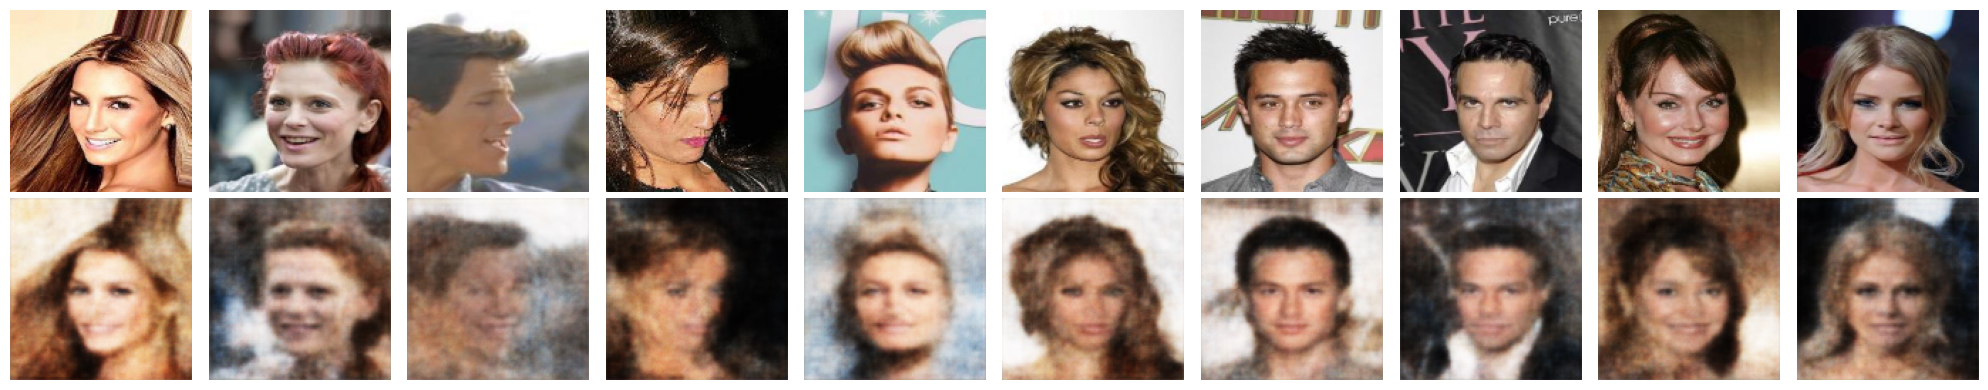

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Nombre d'images à afficher
n = 10  # tu peux ajuster ce nombre

# Préparer les images originales et reconstruites
originals = []
reconstructions = []

for i in range(n):
    test_img = x_train[i]
    test_img_input = np.expand_dims(test_img, axis=0)
    reconstructed_img = autoencodeur.model.predict(test_img_input)[0]

    originals.append(test_img)
    reconstructions.append(reconstructed_img)

# Affichage en grille
plt.figure(figsize=(20, 4))  # Largeur adaptable selon n

for i in range(n):
    # Ligne 1 : originaux
    ax = plt.subplot(2, n, i + 1)
    # First access the NumPy array at index i, then apply the slicing
    plt.imshow(originals[i][..., ::-1])
    plt.axis("off")

    # Ligne 2 : reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    # First access the NumPy array at index i, then apply the slicing
    plt.imshow(reconstructions[i][..., ::-1])
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


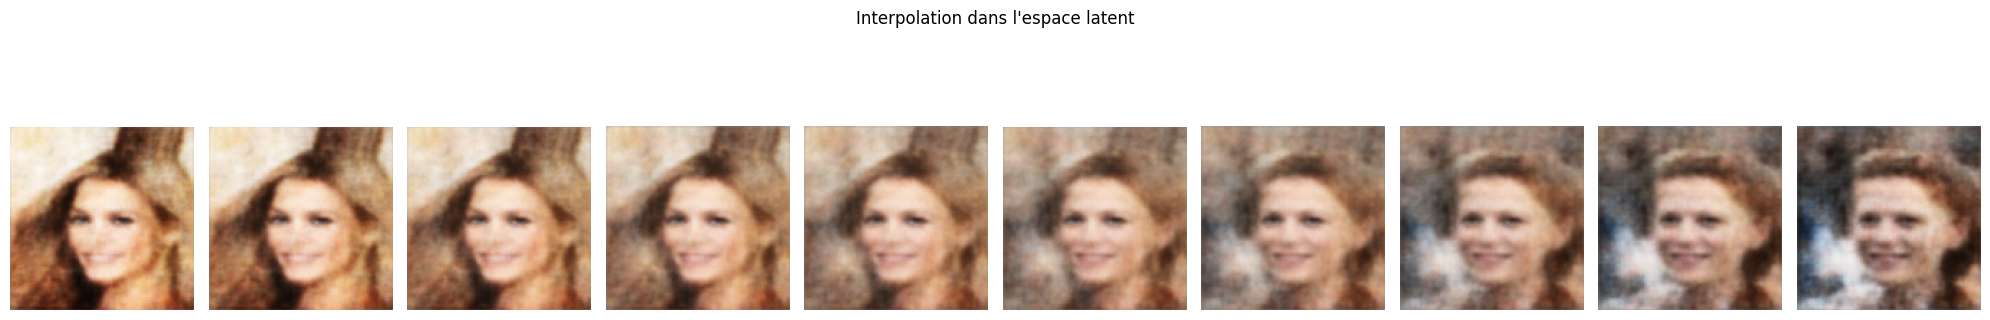

In [25]:
z_start = autoencodeur.encoder.predict(x_train[0:1])
z_end = autoencodeur.encoder.predict(x_train[1:2])
steps = 10
interpolations = np.linspace(z_start, z_end, steps)

# Reshape interpolations to remove the extra dimension
interpolations = interpolations.reshape(steps, autoencodeur.z_dim)

reconstructed = autoencodeur.decoder.predict(interpolations)

plt.figure(figsize=(20, 4))
for i, img in enumerate(reconstructed):
    plt.subplot(1, steps, i + 1)
    plt.imshow(img[..., ::-1])
    plt.axis('off')
plt.suptitle("Interpolation dans l'espace latent")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


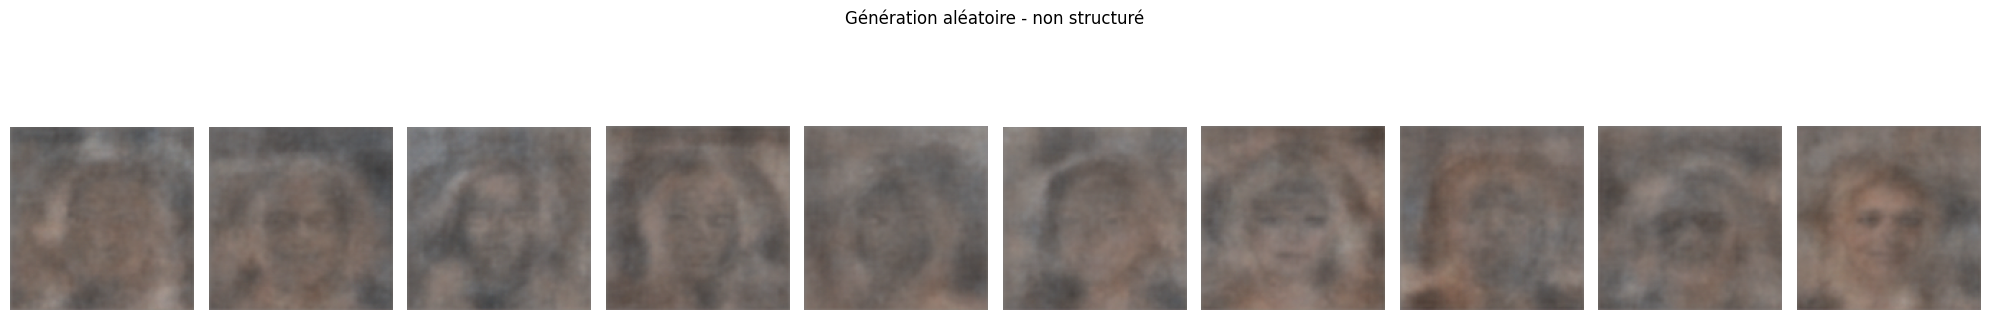

In [21]:
z_samples = np.random.normal(size=(10, autoencodeur.z_dim))
generated_imgs = autoencodeur.decoder.predict(z_samples)

plt.figure(figsize=(20, 4))
for i, img in enumerate(generated_imgs):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[..., ::-1])  # BGR → RGB
    plt.axis('off')
plt.suptitle("Génération aléatoire - non structuré")
plt.tight_layout()
plt.show()


Erreur lors du chargement de /content/drive/MyDrive/img_align_celeba/img_align_celeba/000349.jpg
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


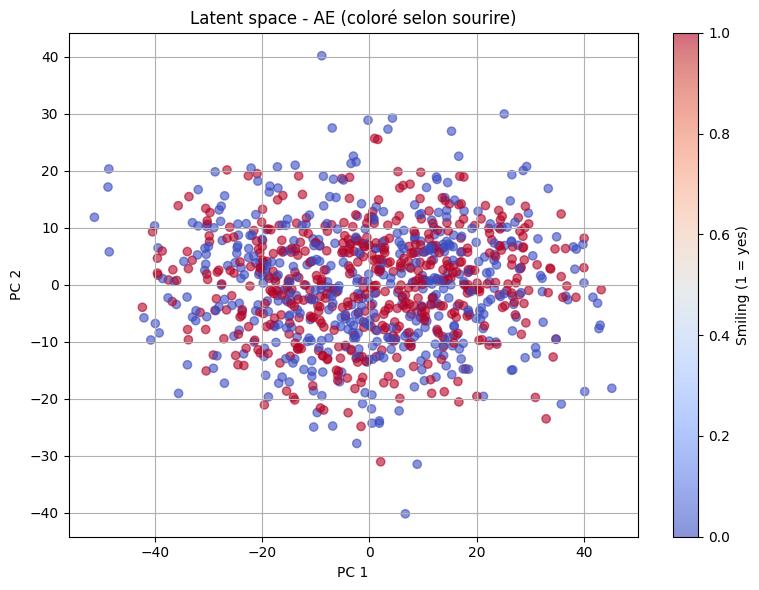

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np # Ensure numpy is imported if used elsewhere

# Chargement des images (déjà fait), on suppose `x_train.shape = (N, 128, 128, 3)`
attr_file = "/content/drive/MyDrive/CelebA/Anno/list_attr_celeba.txt"
attributes_df = pd.read_csv(attr_file, sep="\s+", skiprows=1)

# Chargement des labels associés (extrait depuis list_attr_celeba.txt)

# On extrait les noms de fichiers des chemins d'images chargés.
# Keep track of the original index to filter labels later
image_info = []
for i, fname in enumerate(os.listdir(IMAGE_DIR)):
    if fname.endswith('.jpg'):
        image_info.append((os.path.join(IMAGE_DIR, fname), fname, i))

# Sort by filename to ensure consistent order
image_info.sort(key=lambda x: x[1])

image_paths_full = [info[0] for info in image_info][:1000]
image_filenames_full = [info[1] for info in image_info][:1000]


# === Chargement d’images CelebA ===
def load_images_with_indices(paths):
    images = []
    successful_indices = [] # Store indices of successfully loaded images
    for i, path in enumerate(paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Erreur lors du chargement de {path}")
            continue
        img = cv2.resize(img, IMAGE_SIZE)
        img = img.astype('float32') / 255.0
        images.append(img)
        successful_indices.append(i) # Add the index if loading is successful
    return np.array(images), successful_indices

# Load images and get the indices of those successfully loaded
x_train, successful_indices = load_images_with_indices(image_paths_full)

# Filter filenames and labels based on successful indices
image_filenames_loaded = [image_filenames_full[i] for i in successful_indices]

# Utilisation les noms de fichiers CHARGÉS pour indexer le dataframe attributes_df
smile_labels = attributes_df.loc[image_filenames_loaded, 'Smiling'].values
smile_labels = (smile_labels > 0).astype(int)  # 1 = souriant, 0 = non-souriant

# Encode les images
z_points = autoencodeur.encoder.predict(x_train)

# Réduction en 2D
# Make sure z_pca is calculated based on the actually loaded data
z_pca = PCA(n_components=2).fit_transform(z_points)

# Tracé avec couleur par sourire
plt.figure(figsize=(8, 6))
# Use the filtered smile_labels which now matches the size of z_pca
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=smile_labels, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Smiling (1 = yes)')
plt.title('Latent space - AE (coloré selon sourire)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.tight_layout()
plt.show()